# 2. Modeling

### 2.0 Load Train, Val, Test (Numpy Array)

- Gray Scale : Data_gray 폴더 안에 .npy 파일이 있으면 된다.
- RGB Scale : Data 폴더 안에 .npy 파일이 있으면 된다.

#### Scale 설정
- scale = 'gray'
- scale = 'rgb'

In [1]:
scale = 'rgb'

if scale == 'gray':
    data_dir = 'Data_gray'
    channel = 1
    
elif scale == 'rgb':
    data_dir = 'Data'
    channel = 3

In [2]:
!ls {data_dir}

X_test.npy  X_train.npy  X_val.npy  y_test.npy	y_train.npy  y_val.npy


#### Load Data

In [3]:
import os
import numpy as np

if os.path.exists(data_dir):
    X_train = np.load(data_dir + '/X_train.npy')
    y_train = np.load(data_dir + '/y_train.npy')
    X_val = np.load(data_dir + '/X_val.npy')
    y_val = np.load(data_dir + '/y_val.npy')
    X_test = np.load(data_dir + '/X_test.npy')
    y_test = np.load(data_dir + '/y_test.npy')

    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    print(X_test.shape, y_test.shape)

(330, 64, 128, 128, 3) (330, 8)
(110, 64, 128, 128, 3) (110, 8)
(110, 64, 128, 128, 3) (110, 8)


### 2.1 VGG16 + LSTM

#### 모델 이름 설정

In [4]:
model_name = 'vgg16_lstm'

#### Parameters

In [5]:
epochs = 10
batch_size = 2

### 2.1.1 Model Define

In [10]:
frames = 64
width = 128
height = 128

classes = 8

In [11]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam

video = Input(shape=(frames,
                     width,
                     height,
                     channel))

cnn_base = VGG16(input_shape=(width,
                              height,
                              channel),
                 weights="imagenet",
                 include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)

cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable = False

encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(256)(encoded_frames)

hidden_layer = Dense(units=1024, activation="relu")(encoded_sequence)

outputs = Dense(units=classes, activation="softmax")(hidden_layer)

model = Model(inputs=[video], outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 128, 128, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 64, 512)           14714688  
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 8200      
Total params: 15,773,512
Trainable params: 1,058,824
Non-trainable params: 14,714,688
_________________________________________________________________


### 2.1.2 Model Compile

In [12]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

### 2.1.3 Model Fit

In [13]:
%%time

History = model.fit(X_train, y_train,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data = (X_val, y_val))

Epoch 1/10
165/165 [==============================] - 1718s 10s/step - loss: 2.0461 - accuracy: 0.2666 - val_loss: 1.9392 - val_accuracy: 0.2727
Epoch 2/10
165/165 [==============================] - 1433s 9s/step - loss: 1.5164 - accuracy: 0.5276 - val_loss: 1.8061 - val_accuracy: 0.3636
Epoch 3/10
165/165 [==============================] - 1267s 8s/step - loss: 1.3182 - accuracy: 0.5499 - val_loss: 1.9734 - val_accuracy: 0.3000
Epoch 4/10
165/165 [==============================] - 1385s 8s/step - loss: 1.0592 - accuracy: 0.6319 - val_loss: 2.2696 - val_accuracy: 0.3182
Epoch 5/10
165/165 [==============================] - 1401s 9s/step - loss: 0.8712 - accuracy: 0.7129 - val_loss: 2.6476 - val_accuracy: 0.3909
Epoch 6/10
165/165 [==============================] - 1388s 8s/step - loss: 0.7325 - accuracy: 0.7631 - val_loss: 2.3787 - val_accuracy: 0.3727
Epoch 7/10
165/165 [==============================] - 1143s 7s/step - loss: 0.3808 - accuracy: 0.8704 - val_loss: 2.4051 - val_accuracy

### 2.1.4 Fitted Model Visualization

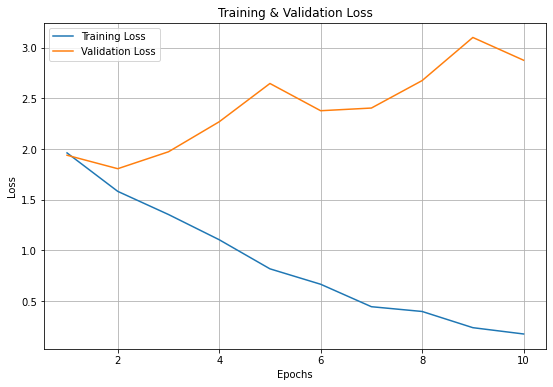

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(History.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History.history['loss'])
plt.plot(epochs, History.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

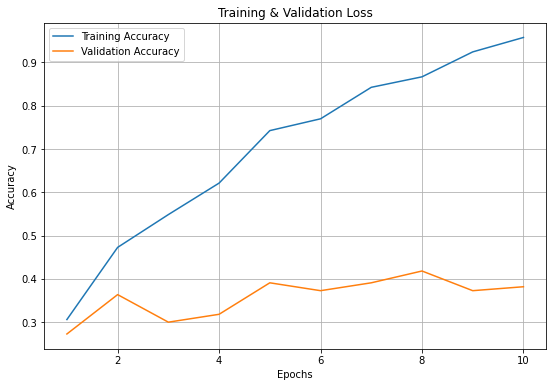

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(History.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History.history['accuracy'])
plt.plot(epochs, History.history['val_accuracy'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

### 2.1.5 Model Evaluate

In [16]:
loss, accuracy = model.evaluate(X_test, y_test,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

55/55 [==============================] - 191s 3s/step - loss: 2.9658 - accuracy: 0.3818
Loss = 2.96582
Accuracy = 0.38182


### 2.1.6 Model Save

In [17]:
save_dir = 'Models'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

final_model_name = '/' + scale + '_' + model_name + '.h5'

model.save(save_dir + final_model_name)

### 2.1.7 Saved Model Test

In [18]:
from keras.models import load_model

rgb_cnn_lstm = load_model(save_dir + final_model_name)

loss, accuracy = rgb_cnn_lstm.evaluate(X_test, y_test,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

55/55 [==============================] - 192s 3s/step - loss: 2.9658 - accuracy: 0.3818
Loss = 2.96582
Accuracy = 0.38182
